In [1]:
import utils as u

from matplotlib.pyplot import *
import matplotlib as mpl

from scipy.fft import *
from scipy.interpolate import UnivariateSpline
from scipy.optimize import fmin
import numpy as np

import numba
@numba.vectorize([numba.float64(numba.complex128),numba.float32(numba.complex64)])
def abs2(x):
    return x.real**2 + x.imag**2

# Constants and parameters

In [2]:
# Constants
nu_darkring = 1.22*np.pi  # location of first airy ring minimum
n = 16                   # N_{Rayleigh} (i.e. number of nu_darkring's to plot)
o = 1                     # bessel function order

n_r = 256                 # N_{Airy} (i.e. number of pixels between peak and first min)
N = n*n_r*2               # size of array and bessel function
N_na = 1.22*(N/2)/n_r     # radius of aperture

downscale_factor = 32     # Degree of downscaling to smooth aperture edge

# Domains
airy_1 = np.linspace(-nu_darkring,nu_darkring,n_r*2)       # domain of first airy ring for unobstructed aperture
airy_n = np.linspace(-nu_darkring*n,nu_darkring*n,n_r*n*2) # domain of nth airy ring

print('Array size =',str(N)+'x'+str(N), '\n',
      '\rAperature radius =',N_na, '\n')

Array size = 8192x8192 
Aperature radius = 19.52 



# Run calculation

In [3]:
# list of fractional diameters for central stop.
b_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# list of locations of first dark ring for a corresponding b from b_list.
nu_b_darkring = [fmin(u.psf, x0 = 2, args = (b,), disp = False, xtol=0.00001)[0] for b in b_list]  

# list of distances to shift the central stop as a percentage of aperture radius.
Num_shifts = 33
shift_percents = np.linspace(0,1, Num_shifts) 

data_dic = {}
for i, b in enumerate(b_list):
    FWHM = []
    fractional_integrated_intensity = []
    # Mask to isolate the central ring by selecting only pixels inside n_b_darkring.
    central_peak_mask = (np.sum((np.mgrid[0:N,0:N]-N/2)**2, axis = 0)**.5)<(n_r*nu_b_darkring[i]/nu_darkring) 
    for j, shift in enumerate(shift_percents):
        print('b:',i+1,'/',len(b_list), ' '*4+'s:',j+1,'/',Num_shifts, end = '     \r')
        # Generate aperture w/ central stop and diffraction pattern.
        a_cs = u.create_aperture(aperture_radius = N_na, array_size = N,
                                 downscale_factor = downscale_factor, b = b, shift_percent = shift)
        A_cs_comp = fftshift(fft2(a_cs, workers=-1), axes = (0,1))
        A_cs = abs2(A_cs_comp)
        A_cs_phase = np.angle(A_cs_comp)
        fractional_integrated_intensity.append(np.sum(A_cs[central_peak_mask])/np.sum(A_cs))
        # fit to spline to get FWHM.
        spline = UnivariateSpline(airy_n, A_cs[A_cs.shape[0]//2,:]-A_cs[A_cs.shape[0]//2,:].max()/2, s = 0)
        r1, r2 = spline.roots()
        FWHM.append(r2-r1)
    
    data_dic[b] = {'FWHM': FWHM, 'FII': fractional_integrated_intensity, 'SP': shift_percents}
np.save('./Offset_results.npy', data_dic)
print('DONE '*10)

DONE DONE DONE DONE DONE DONE DONE DONE DONE DONE 


# Plot data

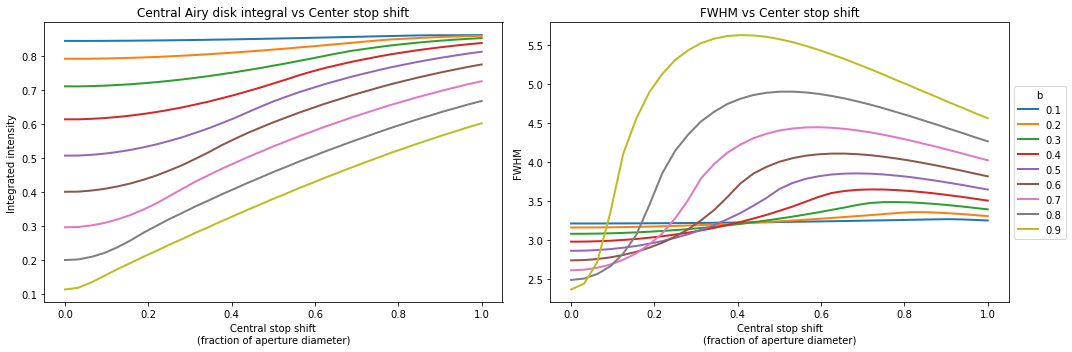

In [4]:
# Load data if skipping the calculation.
np.load('./Offset_results.npy', allow_pickle = True)[()]

fig, axes = subplots(1,2, figsize = (15,5), facecolor = 'white')
mpl.rcParams['lines.linewidth'] = 2
for i, b in enumerate(b_list):
    FWHM = []
    fractional_integrated_intensity = []
    data = data_dic[b]
    axes[0].plot(data['SP'], data['FII'], zorder = 0)
    axes[1].plot(data['SP'], data['FWHM'], zorder = 0, label = np.round(b,2))
    
axes[1].set_ylabel('FWHM')
axes[1].set_xlabel('Central stop shift\n(fraction of aperture diameter)')
axes[0].set_ylabel('Integrated intensity')
axes[0].set_xlabel('Central stop shift\n(fraction of aperture diameter)')
axes[1].legend(title = 'b', loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].set_title('Central Airy disk integral vs Center stop shift')
axes[1].set_title('FWHM vs Center stop shift')
tight_layout()
show()    